# Model Evaluation with AUC-ROC

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Prep test set 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_path = "data/breast_cancer"
dataset = ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes

# split same as at the beginning
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

_, _, test_ds = random_split(dataset, [train_size, val_size, test_size])
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [ ]:
# Loading best model architecture and weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 402),  # note for seld: this is fc1 score
    nn.ReLU(),
    nn.Dropout(0.32744624734009686),       # best_trial dropout
    nn.Linear(402, 3)
)

model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Making predictions
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [ ]:
# Accuracy and classification results
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {acc:.4f}")

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


✅ Test Accuracy: 0.9103

📊 Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.93      0.94        42
   malignant       0.90      0.90      0.90        21
      normal       0.81      0.87      0.84        15

    accuracy                           0.91        78
   macro avg       0.89      0.90      0.89        78
weighted avg       0.91      0.91      0.91        78



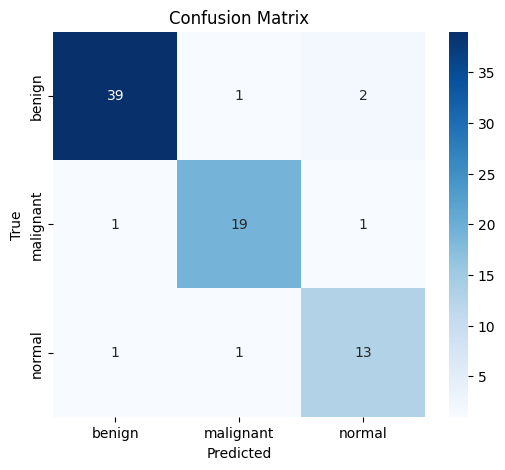

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# AUC-ROC
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
auc = roc_auc_score(y_true_bin, np.array(all_probs), multi_class="ovo")
print(f"✅ AUC-ROC (multi-class): {auc:.4f}")


✅ AUC-ROC (multi-class): 0.9824
